Q10. Load that saved model in another Notebook use it on other dataset for fake news detection.

In [1]:
!pip install gensim


In [2]:
import os
import pickle
import numpy as np
from gensim.models import Word2Vec   # required for unpickling

# Define folder path and filenames
folder_path = '/content/drive/My Drive/IDEAS-TIH/Internship_2025'
filename_rf = os.path.join(folder_path, 'random_forest_w2v_model.pickle')
filename_w2v = os.path.join(folder_path, 'word2vec_model.pickle')

# Load Random Forest model
with open(filename_rf, 'rb') as file:
    rf_clf = pickle.load(file)

# Load Word2Vec model
with open(filename_w2v, 'rb') as file:
    w2v_model = pickle.load(file)

print("✅ Random Forest and Word2Vec models loaded successfully!")

# Function to vectorize new text using Word2Vec
def vectorize(sentence):
    words = sentence.lower().split()  # simple preprocessing
    vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(vecs) == 0:
        return np.zeros(w2v_model.vector_size)
    return np.mean(vecs, axis=0)


✅ Random Forest and Word2Vec models loaded successfully!


In [9]:
import pandas as pd

# Load new datasets
fake_news_df = pd.read_csv('/content/drive/MyDrive/IDEAS-TIH/Internship_2025/BuzzFeed_fake_news_content.csv')
real_news_df = pd.read_csv('/content/drive/MyDrive/IDEAS-TIH/Internship_2025/BuzzFeed_real_news_content.csv')

# Add labels: 0 = fake, 1 = true
fake_news_df['label'] = 0
real_news_df['label'] = 1

# Combine datasets
news_data = pd.concat([fake_news_df, real_news_df], axis=0).reset_index(drop=True)

# Features and target
X_new = news_data['text']
y_new = news_data['label']


In [4]:
import re

def preprocess(text):
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # remove URLs
    text = re.sub(r'[^\w]', ' ', text)  # remove special characters
    text = re.sub(r'\s+', ' ', text)  # remove multiple spaces
    return text

X_new = X_new.apply(preprocess)


In [5]:
def vectorize(sentence):
    words = sentence.split()
    vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(vecs) == 0:
        return np.zeros(w2v_model.vector_size)
    return np.mean(vecs, axis=0)

# Convert all new texts to vectors
X_new_w2v = np.array([vectorize(text) for text in X_new])


In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on new dataset
y_new_pred = rf_clf.predict(X_new_w2v)

# Metrics
accuracy = accuracy_score(y_new, y_new_pred)
precision = precision_score(y_new, y_new_pred)
recall = recall_score(y_new, y_new_pred)
f1 = f1_score(y_new, y_new_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_report(y_new, y_new_pred))



Accuracy: 0.5494505494505495
Precision: 0.7368421052631579
Recall: 0.15384615384615385
F1 Score: 0.2545454545454545

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.95      0.68        91
           1       0.74      0.15      0.25        91

    accuracy                           0.55       182
   macro avg       0.63      0.55      0.47       182
weighted avg       0.63      0.55      0.47       182



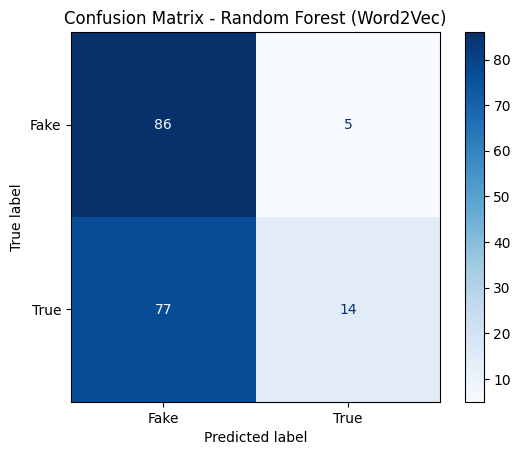

In [7]:
# Confusion Matrix
cm = confusion_matrix(y_new, y_new_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "True"])

# Plot
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Random Forest (Word2Vec)")
plt.show()



Q11(Optional).

Try to enhance the model's accuracy by using adaboost or any other boosting methods.
<br>Use TF-IDF or any other vectorizer instead of Word2Vec and study how much it affects on model's accuracy.

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Boosting models
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier


In [19]:
df_fake = pd.read_csv("/content/drive/MyDrive/IDEAS-TIH/Internship_2025/BuzzFeed_fake_news_content.csv")
df_true = pd.read_csv("/content/drive/MyDrive/IDEAS-TIH/Internship_2025/BuzzFeed_real_news_content.csv")

print("Fake dataset shape:", df_fake.shape)
print("True dataset shape:", df_true.shape)




Fake dataset shape: (91, 12)
True dataset shape: (91, 12)


In [22]:
#add labels
df_fake['label'] = 1   # Fake = 1
df_true['label'] = 0   # True = 0

#combine and shuffle
df = pd.concat([df_fake, df_true], axis=0)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle

print(df.head())          # check first few rows
print(df['label'].value_counts())  # check balance
print(df.columns)         # check actual column names



                id                                              title  \
0  Fake_27-Webpage  How Democrats are Going to Try to STEAL the El...   
1  Fake_48-Webpage  Tebow DISMANTLES national anthem protests in o...   
2  Real_67-Webpage  Terrorist Attacks Will Likely Affect 2016 Pres...   
3  Real_16-Webpage  Young Girl's Emotional Council Speech Laments ...   
4   Real_6-Webpage                      Obama weighs in on the debate   

                                                text  \
0  In every state there is a law governing the me...   
1  20.1k SHARES Facebook Twitter\n\nWhat do Tim T...   
2  The recent connected bombings in New York and ...   
3  Peaceful protesters crowded Charlotte's first ...   
4  Obama weighs in on the debate\n\nPresident Bar...   

                                                 url  \
0  http://eaglerising.com/37044/how-democrats-are...   
1  http://freedomdaily.com/tebow-dismantles-natio...   
2                             http://abcn.ws/2cDjJ92   


In [25]:
#Pick the correct text column
X = df['text']
y = df['label']
#split new dataset
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [26]:
#Vectorize with TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
x_train_tfidf = vectorizer.fit_transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)


In [28]:
#Train boosting models


#adaboost

ada_clf = AdaBoostClassifier(n_estimators=200, random_state=42)
ada_clf.fit(x_train_tfidf, y_train)
y_pred_ada = ada_clf.predict(x_test_tfidf)

print("🔹 AdaBoost Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_ada))
print(classification_report(y_test, y_pred_ada))

#Gradient Boosting

gb_clf = GradientBoostingClassifier(n_estimators=200, random_state=42)
gb_clf.fit(x_train_tfidf, y_train)
y_pred_gb = gb_clf.predict(x_test_tfidf)

print("🔹 Gradient Boosting Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))



🔹 AdaBoost Results:
Accuracy: 0.6756756756756757
              precision    recall  f1-score   support

           0       0.71      0.63      0.67        19
           1       0.65      0.72      0.68        18

    accuracy                           0.68        37
   macro avg       0.68      0.68      0.68        37
weighted avg       0.68      0.68      0.68        37

🔹 Gradient Boosting Results:
Accuracy: 0.7567567567567568
              precision    recall  f1-score   support

           0       0.81      0.68      0.74        19
           1       0.71      0.83      0.77        18

    accuracy                           0.76        37
   macro avg       0.76      0.76      0.76        37
weighted avg       0.76      0.76      0.76        37



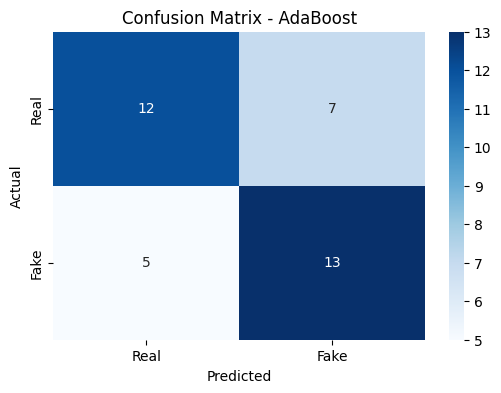

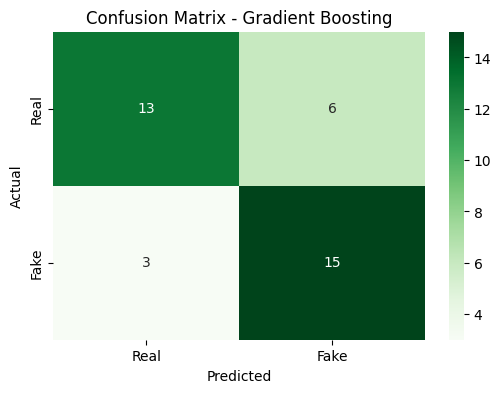

In [30]:
# Confusion matrix for AdaBoost
cm_ada = confusion_matrix(y_test, y_pred_ada)
plt.figure(figsize=(6,4))
sns.heatmap(cm_ada, annot=True, fmt='d', cmap='Blues', xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - AdaBoost")
plt.show()

# Confusion matrix for Gradient Boosting
cm_gb = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(6,4))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Greens', xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Gradient Boosting")
plt.show()

